This tutorial will walk you through how to perform a regression task using supervised machine learning (ML) methods on different types of data that might be relevent for various scientific applications. First we must generate some representative data.

# Generating Data

First, we will generate some nonlinear multi-variate data that will serve as a sufficiently challenging test case for our ML model. The Scikit-Learn library offers some generic routines for generating synthetic data suitable for a range of ML tasks for testing purposes.

In [1]:
# Import the sklearn datasets
import sklearn.datasets as sdt
# Other imports
import numpy as np
import matplotlib.pyplot as plt

For this first example, we will use the Friedman #1 regression function which takes the form: $$f(x)=10sin(\pi x_1 x_2)+ 20(x_3−0.5)^2+10x_4 + 5x_5+ N(0,\sigma) $$

In the following distribution we will create output with 10 features despite the Friedman #1 function only depending upon the first 5 features. We will also add noise to the data to see how well the neural network models can fit perform.

In [2]:
# Create a non-linear distribution using the Friedman #1 function
n_samples = 1000
n_feats = 10
x, y = sdt.make_friedman1(
        n_samples=n_samples,
        n_features=n_feats,
        noise=1.0,
        random_state=42,
)
y = np.expand_dims(y, axis=1)
print(x.shape, y.shape)

(1000, 10) (1000, 1)


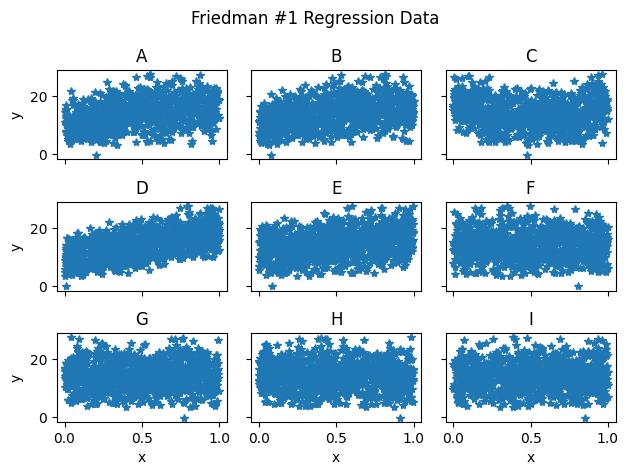

In [3]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Friedman #1 Regression Data')
fig.tight_layout()
plt.show()

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \mu(x)}{\sigma(x)}$$

We can do this manually, or use a number of pre-defined functions in either TensorFlow or sklearn. Here we will use the version that is provided in TensorFlow to show how it might be used, but in other tutorials we can explore different methods.

When creating a normalization function, it is often useful to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [4]:
# Import tensorflow and Normalization layer
import tensorflow as tf
from tensorflow.keras.layers import Normalization

# Create the normalizing function for x and y
normalizer_x = Normalization()
normalizer_y = Normalization()
# Create the inverse normalizing function
inv_normalizer_x = Normalization(invert=True)
inv_normalizer_y = Normalization(invert=True)

# Adapt the normalization layers to the data we created
normalizer_x.adapt(x)
inv_normalizer_x.adapt(x)
normalizer_y.adapt(y)
inv_normalizer_y.adapt(y)

# Now, create scale the data using the normalizers
x_norm = normalizer_x(x)
y_norm = normalizer_y(y)

2024-02-29 09:44:08.119658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


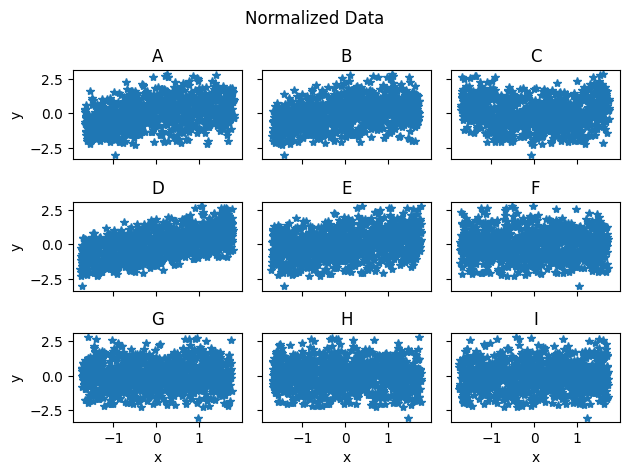

In [5]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x_norm[:,idx], y_norm, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Normalized Data')
fig.tight_layout()
plt.show()

# Creating a ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will be have an input layer, three hidden layer with the number of neurons defined by the `width` variable, and an output layer.

The number of hidden layers, neurons per layer, and a variety of other "hyperparameters" will have a noticable impact on model results. These values can require extensive tuning depending on the problem at hand.

In [70]:
# Import tensorflow layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.initializers import HeUniform

# Define some model hyperparameters
width = 8
l2_norm = 1e-3

# Now we can form the model using TensorFlow functional API

# Input layer connecting input features to the hidden layers
inputs = Input(shape=(None, n_feats))
xtmp = Dense(width, activation='relu', kernel_regularizer=l2(l2_norm))(inputs)
# Three hidden layers with "width" number of neurons, relu activation, and L2 regularization
xtmp = Dense(width, activation='relu', kernel_regularizer=l2(l2_norm))(xtmp)
xtmp = Dense(width, activation='relu', kernel_regularizer=l2(l2_norm))(xtmp)
xtmp = Dense(width, activation='relu', kernel_regularizer=l2(l2_norm))(xtmp)
# Output layer with 1 neuron because there is only 1 output feature
xout = Dense(1, activation=None)(xtmp)

# Define the model
model = Model(inputs=inputs, outputs=xout)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 10)]        0         
                                                                 
 dense_35 (Dense)            (None, None, 8)           88        
                                                                 
 dense_36 (Dense)            (None, None, 8)           72        
                                                                 
 dense_37 (Dense)            (None, None, 8)           72        
                                                                 
 dense_38 (Dense)            (None, None, 8)           72        
                                                                 
 dense_39 (Dense)            (None, None, 1)           9         
                                                                 
Total params: 313 (1.22 KB)
Trainable params: 313 (1.22 KB)

# Creating Train, Validation, and Test Datasets
We will now divide our dataset into three subdatasets for training, validation, and testing.

* Training Dataset: The dataset that we will use to optimize our ML model.
* Validation Dataset: A small, unseen dataset that we will use to monitor the performance of the ML model during training time. This can be useful for tuning hyperparameters and determining if the ML model is overfitting to the seen data.
* Test Dataset: Unseen data that is used to determine the overall performance of the fully-trained model.

In [71]:
from sklearn.model_selection import train_test_split

# Generate train and test datasets with 80-20 split
x_train, x_test, y_train, y_test = train_test_split(x_norm.numpy(), y_norm.numpy(), test_size=0.20, random_state=42)

# Further split the test set into a validation set (final split is 80-10-10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# precompute the unnormalized versions of y
y_train_real = inv_normalizer_y(y_train).numpy()
y_val_real = inv_normalizer_y(y_val).numpy()
y_test_real = inv_normalizer_y(y_test).numpy()


# Training the ML Model
Finally, we will train the ML model.

In [72]:
# Now, we compile the model with Adam optimizer and mean squared error loss
from tensorflow.keras.optimizers import Adam

# Set the learning rate
learning_rate = 1e-3
# Set the optimizer
optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model.compile(loss="mse", optimizer=optimizer)

In [73]:
# Now we can train the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
)

Epoch 1/100
25/25 [==============================] - 1s 8ms/step - loss: 1.0815 - val_loss: 1.0269
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0453 - val_loss: 1.0134
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0322 - val_loss: 1.0069
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0241 - val_loss: 1.0001
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0155 - val_loss: 0.9915
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0052 - val_loss: 0.9758
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9898 - val_loss: 0.9528
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9651 - val_loss: 0.9142
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9259 - val_loss: 0.8560
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8682 - val_loss: 0.7873
Epoch 11/

# Evaluate the Performance

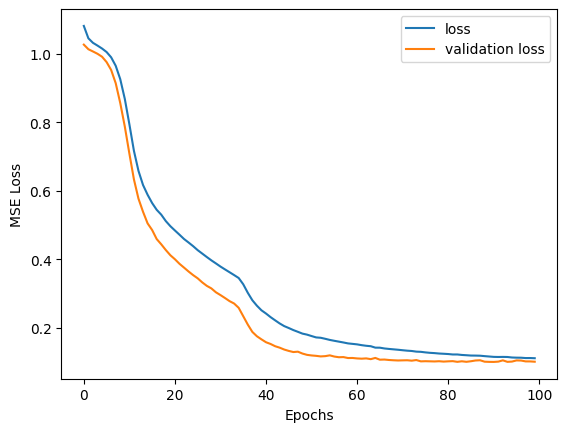

In [74]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [75]:
# Evaluate the model performance on train and validation data
pred_norm = model.predict(x_norm)
pred_norm_train = model.predict(x_train)
pred_norm_val = model.predict(x_val)
pred_norm_test = model.predict(x_test)

# Unscale the results and plot
pred_full = inv_normalizer_y(pred_norm).numpy()
pred_train = inv_normalizer_y(pred_norm_train).numpy()
pred_val = inv_normalizer_y(pred_norm_val).numpy()
pred_test = inv_normalizer_y(pred_norm_test).numpy()

4/4 [==============================] - 0s 1ms/step


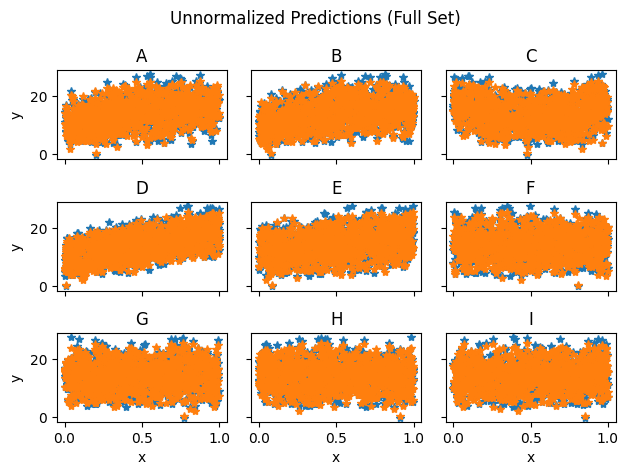

In [76]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred_full, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions (Full Set)')
fig.tight_layout()
plt.show()

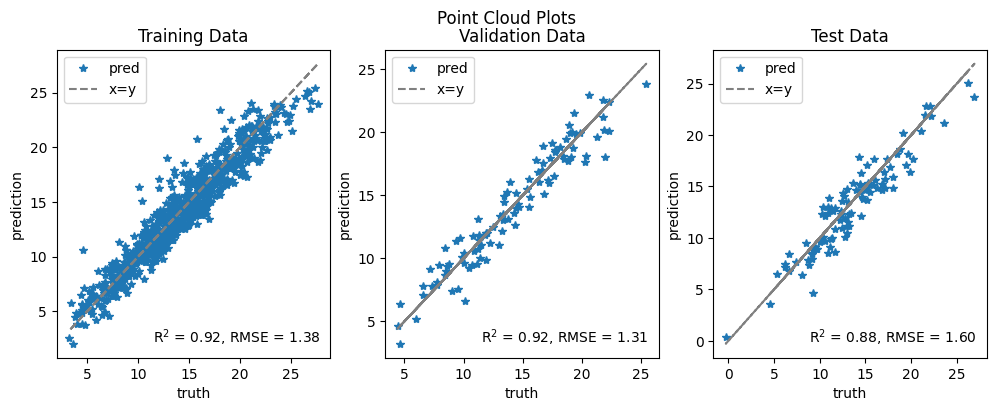

In [77]:
# Compute some statistics on the fit
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2)
    tss = np.sum((truth - np.mean(truth)) ** 2)
    r_sq = 1 - rss / tss
    rmse = np.squeeze(np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0]))
    return r_sq, rmse
    
# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

# Using TF-MELT
We have so far shown how to get started with the basics of initializing, training, and testing a model using TensorFlow basics. While this is important to know, there are many different ML architectures that, along with hyperparameters, can have a larger impact on model results and accuracy. Some architectures are better suited to problems than others, and it can oftentimes involve a great deal of trial-and-error to figure out which ML architectures are best for a given dataset and desired outcomes.

To spead up the process of ML architecture discovery and hyperparamter experimentation, the AI/ML team at NREL has developed a toolbox for TensorFlow that allows for the streamlined implementation of a number of commonly used ML architectures. Here we will show how to get started with TF-MELT. We start by pip installing the TF-MELT repository and importing the ArtificialNeuralNetwork (ANN) architecture.

In [78]:
pip install git+https://github.com/NREL/tf-melt.git --upgrade

  Cloning https://github.com/NREL/tf-melt.git to /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-4548q0zz
  Running command git clone --filter=blob:none --quiet https://github.com/NREL/tf-melt.git /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-4548q0zz
  Resolved https://github.com/NREL/tf-melt.git to commit 428efc282d3703de1e667cacd7aa57684aa7549b
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [79]:
# Import the TF-MELT architecture
from tfmelt.models import ArtificialNeuralNetwork

# Artifical Neural Network (ANN)
Let's create an ANN and explore the impacts hyperparameters on the model.

In [91]:
from tensorflow.keras.optimizers import Adam

# Set some hyperparameters
width = 8
depth = 3
act_fun = "relu"
dropout = 0.0
input_dropout = 0.0
batch_norm = False
l1_reg = 0
l2_reg = 1e-3

loss = "mse"
learning_rate = 1e-3

# Initialize the model with the hyperparameters
model = ArtificialNeuralNetwork(
    num_outputs=1,
    width=width,
    depth=depth,
    act_fun=act_fun,
    dropout=dropout,
    input_dropout=input_dropout,
    batch_norm=batch_norm,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=loss,
)

# Build the model and print a summary
model.build(input_shape=(None, n_feats))
model.summary()

Model: "artificial_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 output (Dense)              multiple                  9         
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                                                 
 bulk_1 (Dense)              multiple                  72        
                                                                 
 bulk_2 (Dense)              multiple                  72        
                                       

In [92]:
# Now we can train the model
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
)

Epoch 1/100
25/25 [==============================] - 1s 9ms/step - loss: 1.0887 - val_loss: 1.0275
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0112 - val_loss: 0.9621
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9495 - val_loss: 0.8936
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8764 - val_loss: 0.8020
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.7855 - val_loss: 0.7006
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6997 - val_loss: 0.6062
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6187 - val_loss: 0.5167
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5528 - val_loss: 0.4563
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5084 - val_loss: 0.4128
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.3747
Epoch 11/

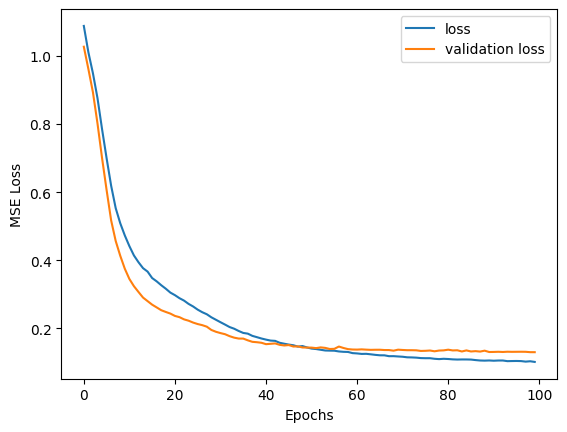

In [93]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [94]:
# Evaluate the model performance on train and validation data
pred_norm = model.predict(x_norm)
pred_norm_train = model.predict(x_train)
pred_norm_val = model.predict(x_val)
pred_norm_test = model.predict(x_test)

# Unscale the results and plot
pred_full = inv_normalizer_y(pred_norm).numpy()
pred_train = inv_normalizer_y(pred_norm_train).numpy()
pred_val = inv_normalizer_y(pred_norm_val).numpy()
pred_test = inv_normalizer_y(pred_norm_test).numpy()

4/4 [==============================] - 0s 2ms/step


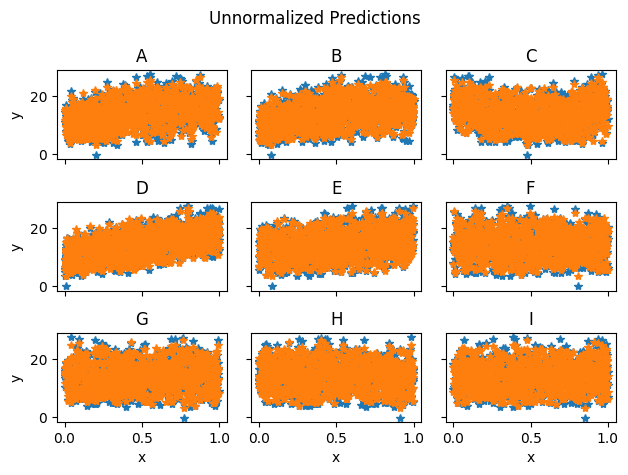

In [95]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred_full, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions')
fig.tight_layout()
plt.show()

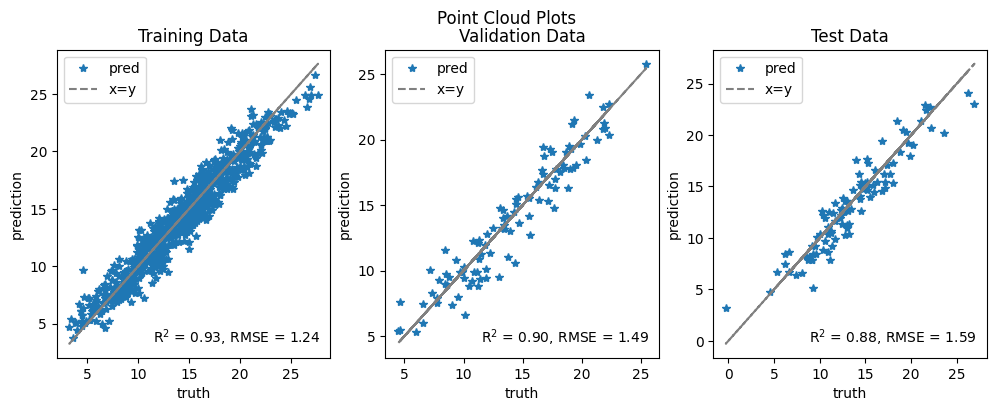

In [96]:
# Compute some statistics on the fit

# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

# Exploration
Here we can see that we have the same results from the model that we built using base TensorFlow and the model that we imported from TF-MELT. Now, let's look an example of how using a generalized tool like TF-MELT can assist in the rapid exploration of architecture parameter space which is often useful when determining optimal settings for machine learning tasks.

## Hyperparameters to explore
* Model depth and width
* Layer regularization
* Layer initialization
* Learning rate
* Batch normalization
* Dropout layers
* Activation functions

## Model Depth
Let's look at the impact of different sets of layers in the neural networks.

Here we will define different models and compare the results. The following example would typically require implementation of separate ML models, but using TF-MELT we can rapidly perform the parameter sweep with just a couple simple `for` loops.

In [125]:
# The default hyperparameter to change...
width = 8
depth = 3
act_fun = "relu"
dropout = 0.0
input_dropout = 0.0
batch_norm = False
l1_reg = 1e-3
l2_reg = 1e-3

loss = "mse"
learning_rate = 1e-3

# Define a vector of different depths to test
depth_vec = [0, 2, 4]
# Loop over the depth vector, create the ANNs, and view the model structure
model_dict = {}
for depth in depth_vec:
    model_dict[depth] = ArtificialNeuralNetwork(
        num_outputs=1,
        width=width,
        depth=depth,
        act_fun=act_fun,
        dropout=dropout,
        input_dropout=input_dropout,
        batch_norm=batch_norm,
        l1_reg=l1_reg,
        l2_reg=l2_reg,
    )
    # Initialize a generic optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the models
    model_dict[depth].compile(
        optimizer=optimizer,
        loss=loss,
    )
    
    # Build and print the model summary
    model_dict[depth].build(input_shape=(None, n_feats))
    model_dict[depth].summary()

Model: "artificial_neural_network_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation)  multiple                 0         
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Model: "artificial_neural_network_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 inp

Using the above TF-MELT structure we can easily create a range of models with different numbers of bulk hidden layers for testing. We can likewise train and evaluate as well.

In [126]:
history = {}
for depth in depth_vec:
    print(f"Training ANN with depth = {depth}")
    history[depth] = model_dict[depth].fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=32,
        shuffle=True,
    )

Training ANN with depth = 0
Epoch 1/100


25/25 [==============================] - 1s 6ms/step - loss: 1.6930 - val_loss: 1.4719
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 1.4945 - val_loss: 1.3201
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 1.3309 - val_loss: 1.1970
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 1.2000 - val_loss: 1.0884
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 1.0851 - val_loss: 0.9906
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.9864 - val_loss: 0.8980
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8943 - val_loss: 0.8144
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8132 - val_loss: 0.7339
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7393 - val_loss: 0.6611
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6717 - val_loss: 0.5901
Epoch 11/100
25/25 [=

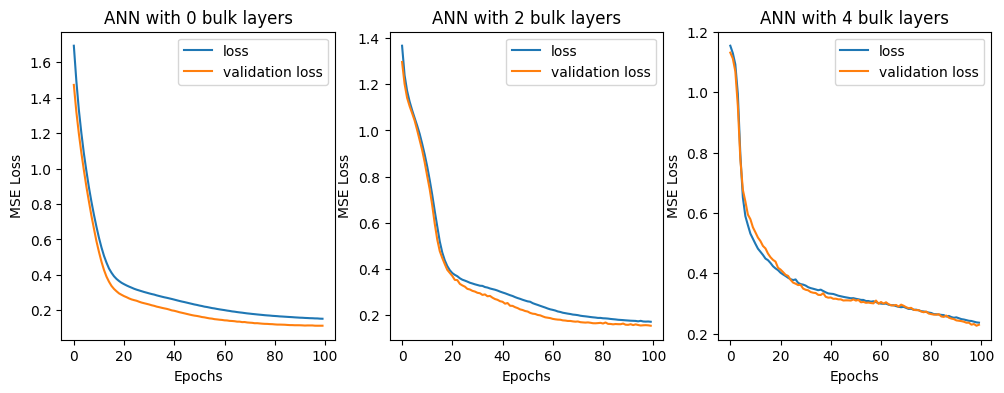

In [127]:
fig, axs = plt.subplots(1, len(depth_vec), figsize=(4*len(depth_vec), 4))
for idx, depth in enumerate(depth_vec):
    axs[idx].plot(history[depth].history["loss"], label="loss")
    axs[idx].plot(history[depth].history["val_loss"], label="validation loss")
    axs[idx].legend()
    axs[idx].set_xlabel("Epochs")
    axs[idx].set_ylabel("MSE Loss")
    axs[idx].set_title(f"ANN with {depth} bulk layers")
    
plt.show()

As the number of hidden layers increases, so too does the ability for the ANN to capture more complex relationships. Here we see that as the depth increases, the loss decreases, but the validation loss begins to stagnate. This is a sign that the ANN is overfitting to the training set.

4/4 [==============================] - 0s 818us/step


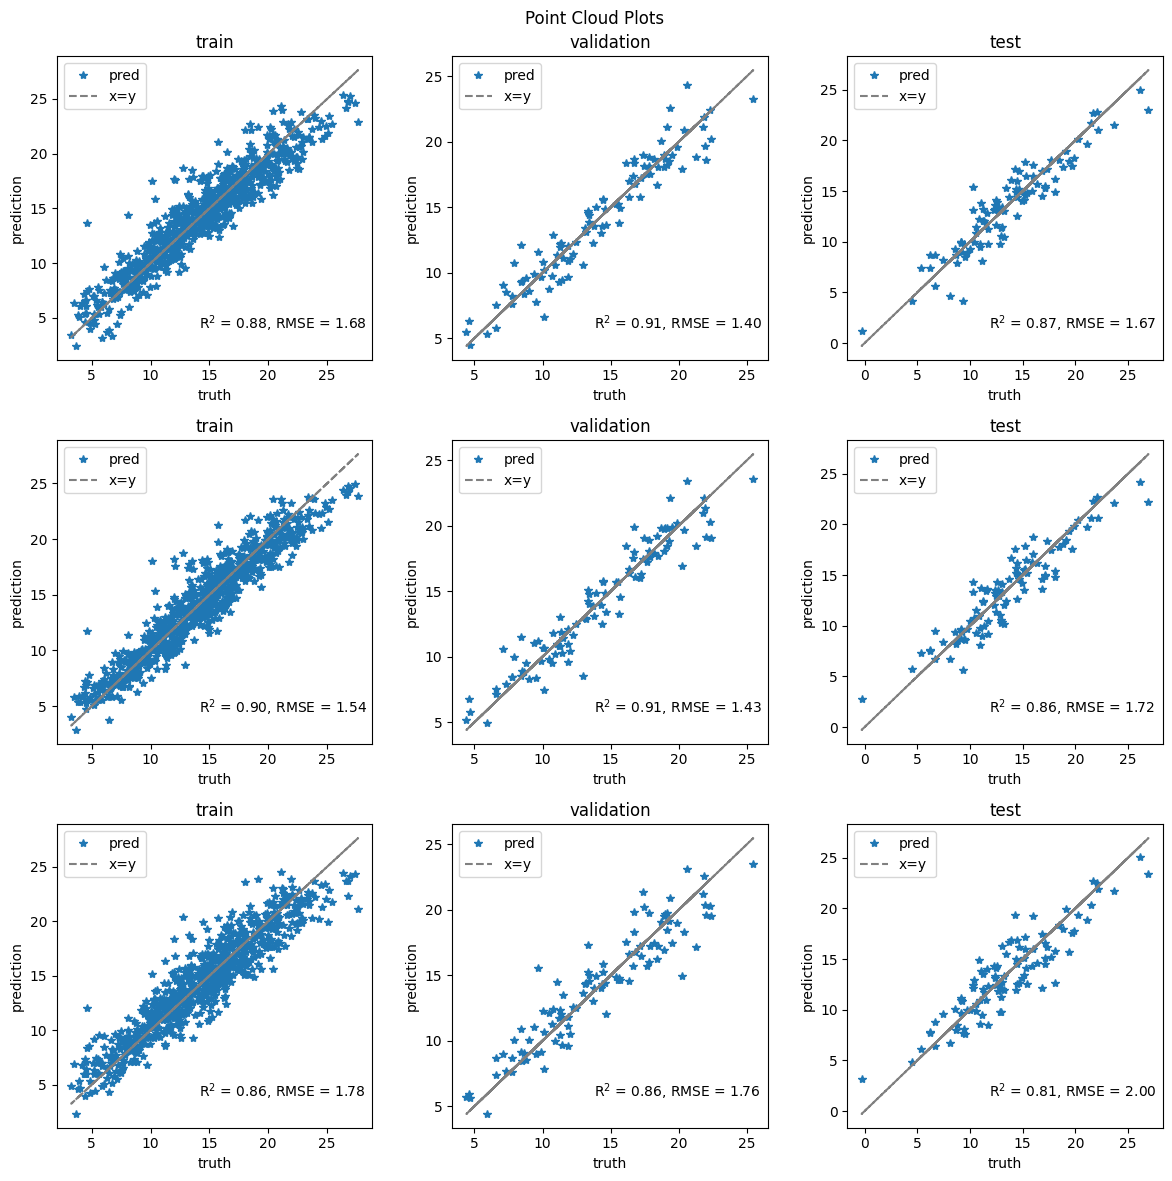

In [128]:
fig, axs = plt.subplots(len(depth_vec), 3, figsize=(4*len(depth_vec), 4*3))
# Evaluate the model performance
for idx, depth in enumerate(depth_vec):
    pred_norm_train = model_dict[depth].predict(x_train)
    pred_norm_val = model_dict[depth].predict(x_val)
    pred_norm_test = model_dict[depth].predict(x_test)
    
    # Unscale the results and plot
    pred_train = inv_normalizer_y(pred_norm_train).numpy()
    pred_val = inv_normalizer_y(pred_norm_val).numpy()
    pred_test = inv_normalizer_y(pred_norm_test).numpy()

    # Compute some statistics on the fit
    r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
    r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
    r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)
    # Visualize the predictions using a cloud plot
    ax0 = axs[idx, 0]
    ax1 = axs[idx, 1]
    ax2 = axs[idx, 2]
    # Training data
    ax0.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
    ax0.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
    ax0.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax0.transAxes)
    ax0.legend()
    ax0.set_xlabel("truth")
    ax0.set_ylabel("prediction")
    ax0.set_title("train")
    # Validation data
    ax1.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
    ax1.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
    ax1.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("validation")
    # Test data
    ax2.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
    ax2.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
    ax2.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("test")
    
fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

We can see from the prediction plots that the the training predictions are improving, but the predictions on unseen data is actually worse than it was with the small model.

## Regularization
One simple way to prevent a model from overfitting is to use regularization techniques. There are a variety of these methods that we can explore:

* L1 and L2 regularization values
* Batch normalization
* Dropout layers

Let's recreate our models but now use some regularization techniques...

In [97]:
# from tfmelt.models import ResidualNeuralNetwork

# Redefine some hyperparameters for regularization
width = 8
l1_reg = 1e-3
l2_reg = 1e-3
dropout = 0.0
input_dropout = 0.0
batch_norm = False

# Define a vector of different depths to test
depth_vec = [0, 2, 4]
# Loop over the depth vector, create the ANNs, and view the model structure
model_dict = {}
for depth in depth_vec:
    model_dict[depth] = ArtificialNeuralNetwork(
    # model_dict[depth] = ResidualNeuralNetwork(
        num_outputs=1,
        width=width,
        depth=depth,
        act_fun=act_fun,
        dropout=dropout,
        input_dropout=input_dropout,
        batch_norm=batch_norm,
        l1_reg=l1_reg,
        l2_reg=l2_reg,
    )
    # Initialize a generic optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the models
    model_dict[depth].compile(
        optimizer=optimizer,
        loss=loss,
    )
    
    # Build and print the model summary
    model_dict[depth].build(input_shape=(None, n_feats))
    model_dict[depth].summary()

Model: "artificial_neural_network_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation)  multiple                 0         
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


Model: "artificial_neural_network_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation)  multiple                 0         
                                                                 
 output (Dense)              multiple                  9         
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                                                 
 bulk_1 (Dense)              multiple                  72        
                                                                 
 bulk_act_0 (Activation)     multiple                  0         
                                                                 
 bulk_act_1 (Activation)     multiple 

In [98]:
history = {}
for depth in depth_vec:
    print(f"Training ANN with depth = {depth}")
    history[depth] = model_dict[depth].fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        shuffle=True,
    )

Training ANN with depth = 0
Epoch 1/200


25/25 [==============================] - 1s 4ms/step - loss: 1.4308 - val_loss: 1.0935
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 1.2308 - val_loss: 0.9417
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 1.0763 - val_loss: 0.8277
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.9576 - val_loss: 0.7324
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.8606 - val_loss: 0.6572
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.7824 - val_loss: 0.5951
Epoch 7/200
25/25 [==============================] - 0s 2ms/step - loss: 0.7176 - val_loss: 0.5447
Epoch 8/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6633 - val_loss: 0.5033
Epoch 9/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6162 - val_loss: 0.4667
Epoch 10/200
25/25 [==============================] - 0s 2ms/step - loss: 0.5784 - val_loss: 0.4364
Epoch 11/200
25/25 [=

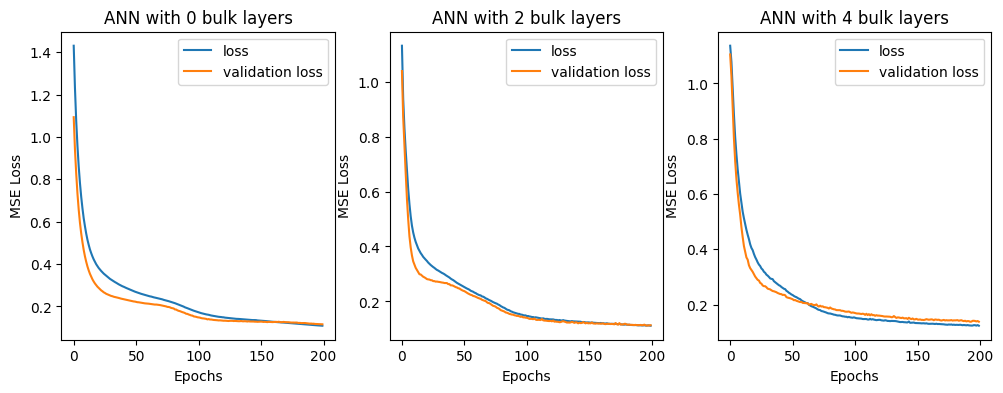

In [103]:
fig, axs = plt.subplots(1, len(depth_vec), figsize=(4*len(depth_vec), 4))
for idx, depth in enumerate(depth_vec):
    axs[idx].plot(history[depth].history["loss"], label="loss")
    axs[idx].plot(history[depth].history["val_loss"], label="validation loss")
    axs[idx].legend()
    axs[idx].set_xlabel("Epochs")
    axs[idx].set_ylabel("MSE Loss")
    axs[idx].set_title(f"ANN with {depth} bulk layers")
    
plt.show()

4/4 [==============================] - 0s 781us/step


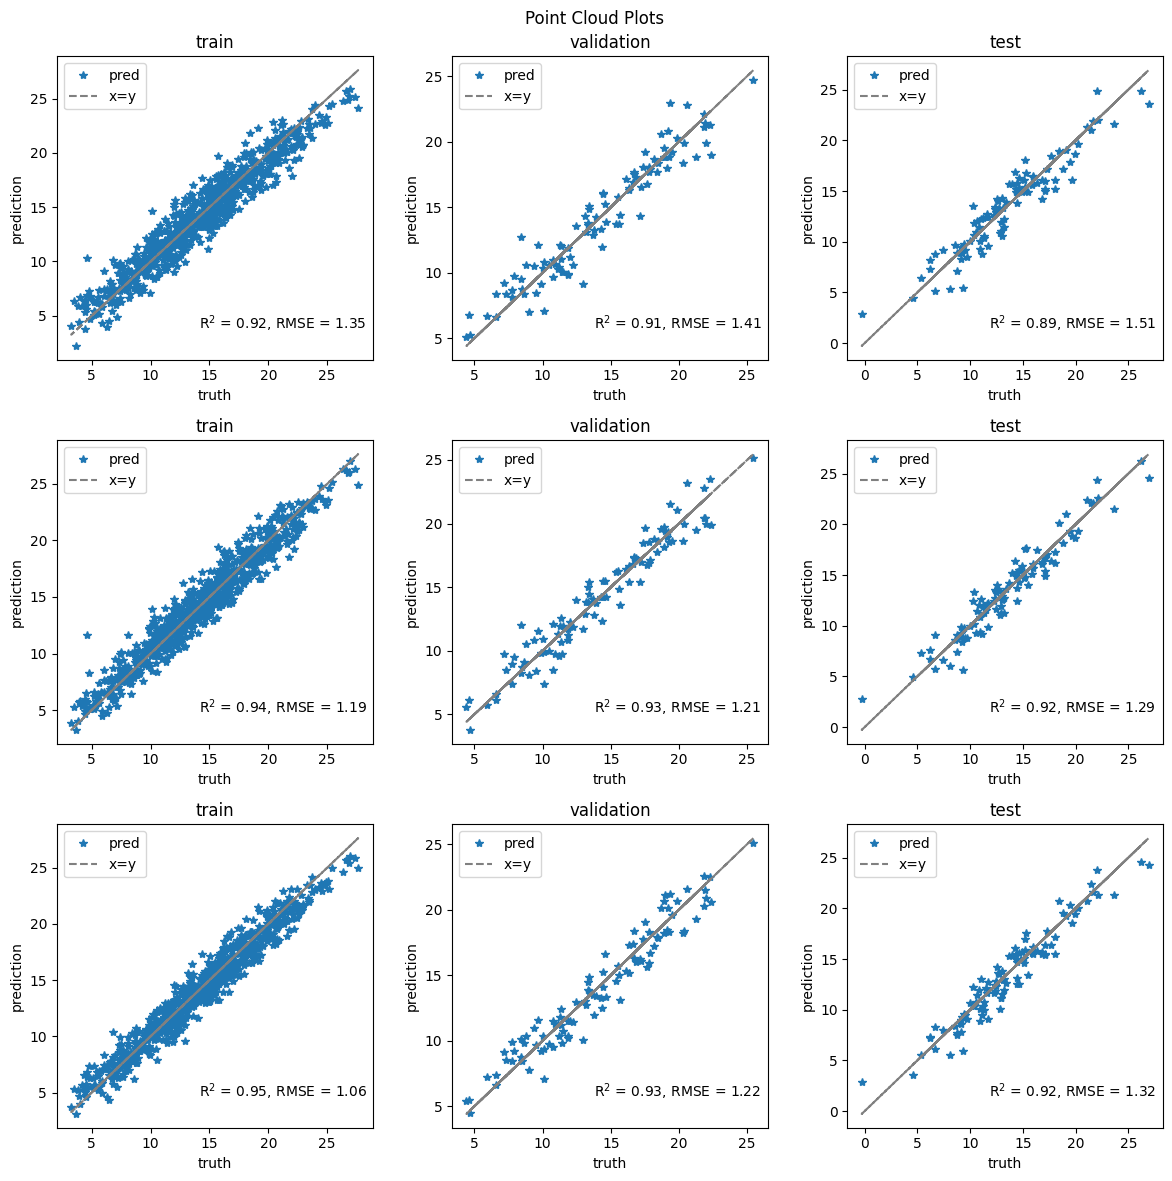

In [104]:
fig, axs = plt.subplots(len(depth_vec), 3, figsize=(4*len(depth_vec), 4*3))
# Evaluate the model performance
for idx, depth in enumerate(depth_vec):
    pred_norm_train = model_dict[depth].predict(x_train)
    pred_norm_val = model_dict[depth].predict(x_val)
    pred_norm_test = model_dict[depth].predict(x_test)
    
    # Unscale the results and plot
    pred_train = inv_normalizer_y(pred_norm_train).numpy()
    pred_val = inv_normalizer_y(pred_norm_val).numpy()
    pred_test = inv_normalizer_y(pred_norm_test).numpy()

    # Compute some statistics on the fit
    r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
    r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
    r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)
    # Visualize the predictions using a cloud plot
    ax0 = axs[idx, 0]
    ax1 = axs[idx, 1]
    ax2 = axs[idx, 2]
    # Training data
    ax0.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
    ax0.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
    ax0.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax0.transAxes)
    ax0.legend()
    ax0.set_xlabel("truth")
    ax0.set_ylabel("prediction")
    ax0.set_title("train")
    # Validation data
    ax1.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
    ax1.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
    ax1.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("validation")
    # Test data
    ax2.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
    ax2.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
    ax2.text(x=0.45, y=0.10, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("test")
    
fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

# Conclusions
We have preprocessed data, built a neural network model, trained the model, and evaluated its performance.

We have shown how hyperparameters can impact the training and evaluation of the model on a regression task.

Future examples will delve into extracting uncertainty estimates from model predictions on regression tasks and more advanced NN architectures.